### Part 1: Machine Learning & Regression Concepts

This section establishes the fundamental problem of supervised learning: fitting a model to noisy data and evaluating its ability to generalize.

* **Objective:** To visually and quantitatively demonstrate the concepts of **underfitting** and **overfitting**.
* **Methodology:**
    1.  A "true" non-linear function ($f(x) = 0.5x^2$) is defined.
    2.  Noisy synthetic data is generated from this function ($y = f(x) + \epsilon$).
    3.  The data is split into **training** and **test** sets.
    4.  Polynomial models of varying degrees (e.g., 1, 2, 10, 20) are fit to the training data.



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# # Set matplotlib style (gracefully handle if style doesn't exist)
# try:
#     plt.style.use('seaborn-v0_8-darkgrid')
# except:
#     try:
#         plt.style.use('seaborn-darkgrid')
#     except:
#         pass  # Use default style

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


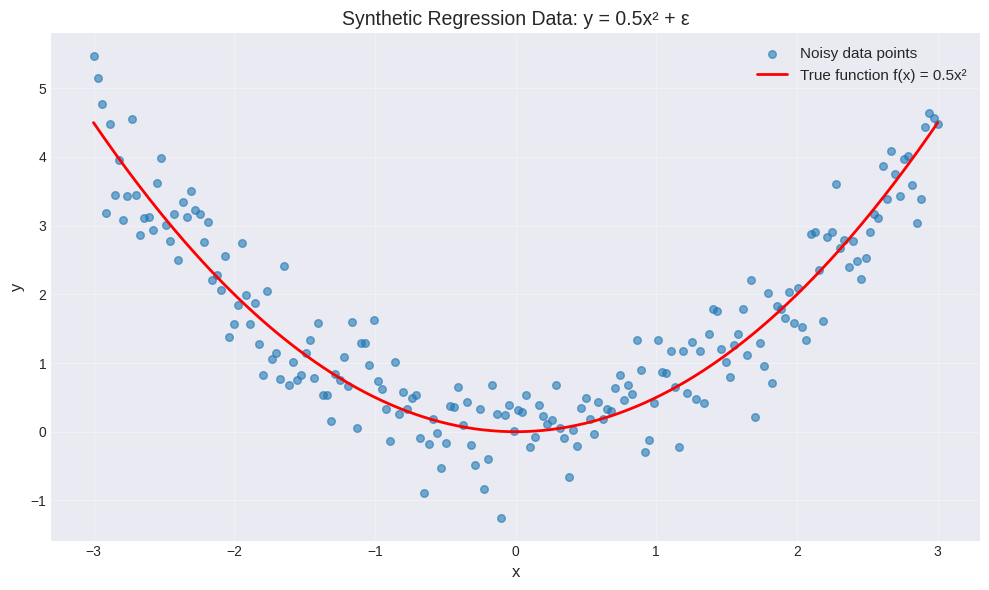

Generated 200 samples
X range: [-3.0, 3.0]
Noise standard deviation σ = 0.5


In [2]:
# Generate synthetic data: y = 0.5 * x² + ε where ε ~ N(0, σ²)
n_samples = 200
x_min, x_max = -3.0, 3.0
sigma = 0.5

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values
y_true = 0.5 * x ** 2

# Generate noise ε ~ N(0, σ²)
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))

# Generate noisy observations
y = y_true + epsilon

# Plot true function and noisy data points
x_plot = torch.linspace(x_min, x_max, 300).unsqueeze(1)
y_plot_true = 0.5 * x_plot ** 2

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), alpha=0.6, label='Noisy data points', s=30)
plt.plot(x_plot.numpy(), y_plot_true.numpy(), 'r-', linewidth=2, label='True function f(x) = 0.5x²')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Synthetic Regression Data: y = 0.5x² + ε', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Generated {n_samples} samples")
print(f"X range: [{x_min}, {x_max}]")
print(f"Noise standard deviation σ = {sigma}")


## Train/Test Split

The **train/test split** is a fundamental concept in supervised learning that helps us evaluate how well our model generalizes to unseen data. Minimizing the loss function is the goal of pure optimization. But in machine learning, we must minimize the loss while also ensuring our model generalizes to new data

### Purpose

- **Training set**: Used to fit the model parameters. The model learns patterns from this data.
- **Test set**: Used to evaluate the model's performance on data it has never seen during training.

### Generalization

**Generalization** refers to a model's ability to perform well on new, unseen data. A model that performs well on training data but poorly on test data is said to have poor generalization—it has memorized the training data rather than learned the underlying pattern.

### Why It Matters

- **Prevents overfitting detection**: The test set serves as an unbiased estimate of model performance
- **Model selection**: Helps choose between different models or hyperparameters
- **Real-world performance**: The test set performance is a better indicator of how the model will perform in practice


In [3]:
# Split dataset into training and test sets
train_ratio = 0.8
n_train = int(n_samples * train_ratio)
n_test = n_samples - n_train

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

# Display summary statistics
print("=" * 60)
print("Training Set Summary Statistics")
print("=" * 60)
print(f"Number of samples: {n_train}")
print(f"X - Mean: {x_train.mean().item():.4f}, Std: {x_train.std().item():.4f}, Min: {x_train.min().item():.4f}, Max: {x_train.max().item():.4f}")
print(f"Y - Mean: {y_train.mean().item():.4f}, Std: {y_train.std().item():.4f}, Min: {y_train.min().item():.4f}, Max: {y_train.max().item():.4f}")

print("\n" + "=" * 60)
print("Test Set Summary Statistics")
print("=" * 60)
print(f"Number of samples: {n_test}")
print(f"X - Mean: {x_test.mean().item():.4f}, Std: {x_test.std().item():.4f}, Min: {x_test.min().item():.4f}, Max: {x_test.max().item():.4f}")
print(f"Y - Mean: {y_test.mean().item():.4f}, Std: {y_test.std().item():.4f}, Min: {y_test.min().item():.4f}, Max: {y_test.max().item():.4f}")
print("=" * 60)


Training Set Summary Statistics
Number of samples: 160
X - Mean: -0.0253, Std: 1.6977, Min: -3.0000, Max: 3.0000
Y - Mean: 1.4484, Std: 1.4002, Min: -1.2492, Max: 5.4635

Test Set Summary Statistics
Number of samples: 40
X - Mean: 0.1010, Std: 1.9432, Min: -2.9698, Max: 2.9095
Y - Mean: 1.8965, Std: 1.4249, Min: -0.3947, Max: 5.1536


## Mean Squared Error (MSE)

*Mean Squared Error (MSE)* is a common metric for measuring the quality of regression predictions.

### Definition

For a set of $n$ predictions, MSE is defined as:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{true}}^{(i)} - y_{\text{pred}}^{(i)})^2$$

where:
- $y_{\text{true}}^{(i)}$ is the true value for the $i$-th sample
- $y_{\text{pred}}^{(i)}$ is the predicted value for the $i$-th sample
- $n$ is the number of samples

### Note that:

- MSE measures the average squared difference between predicted and true values
- The squaring ensures that large errors are penalized more heavily than small errors
- Both positive and negative errors contribute (no cancellation)

### MSE can be decomposed into three components:
$$E[\text{Error}] = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$


### Bias and Variance
Let the true function be $y = f(x) + \epsilon$, where $\epsilon$ is random noise. We use a training set $D$ to build a model, $\hat{f}(x)$.

The **bias** of our model at a point $x_0$ is the difference between the *expected prediction* of our model and the *true value* of the function at that point. The expectation $E[\hat{f}(x_0)]$ is taken over all possible training sets $D$ of a given size.

$$\text{Bias}(\hat{f}(x_0)) = E[\hat{f}(x_0)] - f(x_0)$$

**Variance** is the expected value of the squared difference between any one model's prediction $\hat{f}(x_0)$ (trained on a specific dataset $D$) and the *average prediction* $E[\hat{f}(x_0)]$ (over all possible datasets).

$$\text{Variance}(\hat{f}(x_0)) = E\left[ (\hat{f}(x_0) - E[\hat{f}(x_0)])^2 \right]$$

In the context of the Bias-Variance decomposition, this term appears as Bias-squared: $(E[\hat{f}(x_0)] - f(x_0))^2$. *High Bias means the model is too simple and is underfitting the data. High Variance means the model is too complex and is overfitting the data.*


**A model with high bias (underfitting) or high variance (overfitting) will have high MSE on the test set.**


In [4]:
# Define MSE function using Einstein summation
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    # Use einsum for efficient computation: 'i,i->' computes sum of element-wise product
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

# Polynomial feature expansion function
def create_polynomial_features(x, degree):
    """
    Create polynomial features up to specified degree.
    For degree d, creates features: [1, x, x², ..., x^d]
    """
    features = torch.stack([x.squeeze() ** i for i in range(degree + 1)], dim=1)
    return features

# Function to fit polynomial regression using least squares
def fit_polynomial_regression(x_train, y_train, degree):
    """
    Fit polynomial regression of specified degree using least squares.
    Returns the coefficients.
    """
    # Create polynomial features
    X_train_poly = create_polynomial_features(x_train, degree)
    
    # Least squares solution: w = (X^T X)^(-1) X^T y
    # Using einsum for matrix operations
    # XTX = X^T X: (n, d) @ (d, n) -> (d, d)
    XTX = torch.einsum('ij,ik->jk', X_train_poly, X_train_poly)
    # XTy = X^T y: (d, n) @ (n, 1) -> (d, 1)
    # Squeeze y to (n,) for cleaner einsum, then unsqueeze result
    y_flat = y_train.squeeze()
    XTy = torch.einsum('ij,i->j', X_train_poly, y_flat).unsqueeze(1)
    
    # Solve for coefficients
    try:
        coefficients = torch.linalg.solve(XTX, XTy)
    except:
        # If singular, use pseudo-inverse
        coefficients = torch.linalg.pinv(XTX) @ XTy
    
    return coefficients

# Function to predict using polynomial coefficients
def predict_polynomial(x, coefficients):
    """
    Predict using polynomial coefficients.
    """
    degree = coefficients.shape[0] - 1
    X_poly = create_polynomial_features(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X_poly, coefficients)
    return y_pred

# Fit models of varying degree
degrees = [1, 2, 3, 4, 5, 6, 7]
models = {}
train_mses = []
test_mses = []

print("Fitting polynomial regression models...")
print("=" * 60)

for degree in degrees:
    # Fit model
    coefficients = fit_polynomial_regression(x_train, y_train, degree)
    models[degree] = coefficients
    
    # Predict on training and test sets
    y_train_pred = predict_polynomial(x_train, coefficients)
    y_test_pred = predict_polynomial(x_test, coefficients)
    
    # Compute MSE
    train_mse = compute_mse(y_train, y_train_pred)
    test_mse = compute_mse(y_test, y_test_pred)
    
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    
    print(f"Degree {degree:2d}: Train MSE = {train_mse:.6f}, Test MSE = {test_mse:.6f}")

print("=" * 60)

# Display results in a table
print("\nSummary Table:")
print("-" * 60)
print(f"{'Degree':<10} {'Train MSE':<15} {'Test MSE':<15} {'Difference':<15}")
print("-" * 60)
for i, degree in enumerate(degrees):
    diff = test_mses[i] - train_mses[i]
    print(f"{degree:<10} {train_mses[i]:<15.6f} {test_mses[i]:<15.6f} {diff:<15.6f}")
print("-" * 60)


Fitting polynomial regression models...
Degree  1: Train MSE = 1.948196, Test MSE = 2.179508
Degree  2: Train MSE = 0.234832, Test MSE = 0.253448
Degree  3: Train MSE = 0.230459, Test MSE = 0.269811
Degree  4: Train MSE = 0.228960, Test MSE = 0.280452
Degree  5: Train MSE = 0.228916, Test MSE = 0.283213
Degree  6: Train MSE = 0.227170, Test MSE = 0.292336
Degree  7: Train MSE = 0.225774, Test MSE = 0.295474

Summary Table:
------------------------------------------------------------
Degree     Train MSE       Test MSE        Difference     
------------------------------------------------------------
1          1.948196        2.179508        0.231312       
2          0.234832        0.253448        0.018615       
3          0.230459        0.269811        0.039352       
4          0.228960        0.280452        0.051492       
5          0.228916        0.283213        0.054297       
6          0.227170        0.292336        0.065166       
7          0.225774        0.295474   

## Underfitting and Overfitting

### Underfitting (High Bias, Low Variance)

**Underfitting** occurs when a model is too simple to capture the underlying pattern in the data.

- **Characteristics**:
  - Model is not complex enough
  - High bias: systematic error due to oversimplified assumptions
  - Low variance: model predictions are stable but inaccurate
  - Both training and test errors are high
  - Model fails to learn the training data well

- **Example**: A linear model (degree 1) trying to fit a quadratic relationship. No matter what training data (drawn from the parabola) we give our linear model, the best it can do is find a line that cuts through the parabola. If we averaged all the possible lines we could fit, we would get an "average line." This average line is systematically different from the true parabolic function. The gap between this average line and the true parabola is the bias. It is a fundamental, structural error that no amount of additional data can fix, because our model's assumption (that the world is linear) is incorrect.

### Overfitting (Low Bias, High Variance)

**Overfitting** occurs when a model is too complex and learns the noise in the training data rather than the underlying pattern.

- **Characteristics**:
  - Model is too complex relative to the data
  - Low bias: model can fit training data very well
  - High variance: model predictions are sensitive to small changes in training data
  - Training error is low, but test error is high
  - Large gap between training and test performance

- **Example**: A high-degree polynomial (degree 10) that passes through every training point but oscillates wildly between points

### Bias-Variance Tradeoff

The **bias-variance tradeoff** is a fundamental concept in machine learning:

- **Increasing model complexity**: 
  - Decreases bias (better fit to training data)
  - Increases variance (more sensitive to training data noise)
  
- **Decreasing model complexity**:
  - Increases bias (worse fit to training data)
  - Decreases variance (more stable predictions)

- **Optimal complexity**: Balance between bias and variance to minimize generalization error


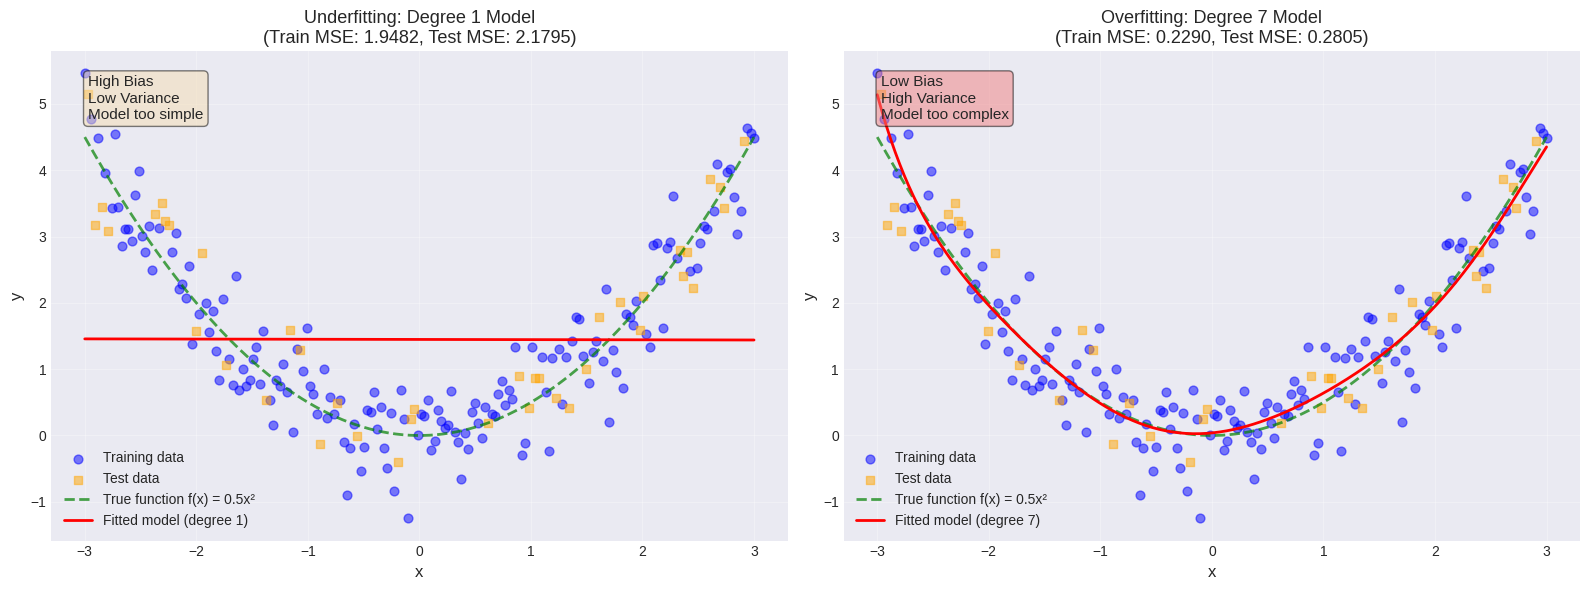

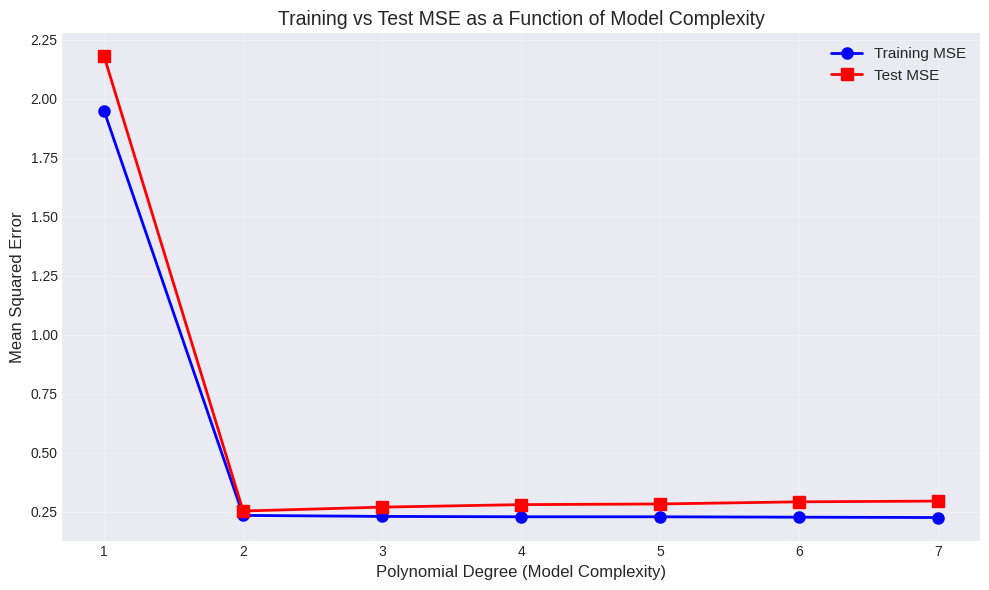

In [5]:
# Create side-by-side visualization for underfitting and overfitting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Generate smooth x values for plotting fitted curves
x_plot_smooth = torch.linspace(x_min, x_max, 300).unsqueeze(1)
y_plot_true_smooth = 0.5 * x_plot_smooth ** 2

# Plot 1: Underfitting (degree 1)
degree_low = 1
coefficients_low = models[degree_low]
y_plot_pred_low = predict_polynomial(x_plot_smooth, coefficients_low)

axes[0].scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training data', s=40, color='blue')
axes[0].scatter(x_test.numpy(), y_test.numpy(), alpha=0.5, label='Test data', s=40, color='orange', marker='s')
axes[0].plot(x_plot_smooth.numpy(), y_plot_true_smooth.numpy(), 'g--', linewidth=2, label='True function f(x) = 0.5x²', alpha=0.7)
axes[0].plot(x_plot_smooth.numpy(), y_plot_pred_low.numpy(), 'r-', linewidth=2, label=f'Fitted model (degree {degree_low})')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title(f'Underfitting: Degree {degree_low} Model\n(Train MSE: {train_mses[0]:.4f}, Test MSE: {test_mses[0]:.4f})', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, 'High Bias\nLow Variance\nModel too simple', 
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Overfitting (degree 7)
degree_high = 7
coefficients_high = models[degree_high]
y_plot_pred_high = predict_polynomial(x_plot_smooth, coefficients_high)

axes[1].scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training data', s=40, color='blue')
axes[1].scatter(x_test.numpy(), y_test.numpy(), alpha=0.5, label='Test data', s=40, color='orange', marker='s')
axes[1].plot(x_plot_smooth.numpy(), y_plot_true_smooth.numpy(), 'g--', linewidth=2, label='True function f(x) = 0.5x²', alpha=0.7)
axes[1].plot(x_plot_smooth.numpy(), y_plot_pred_high.numpy(), 'r-', linewidth=2, label=f'Fitted model (degree {degree_high})')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title(f'Overfitting: Degree {degree_high} Model\n(Train MSE: {train_mses[3]:.4f}, Test MSE: {test_mses[3]:.4f})', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, 'Low Bias\nHigh Variance\nModel too complex', 
             transform=axes[1].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

# Additional visualization: MSE vs Model Complexity
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mses, 'o-', linewidth=2, markersize=8, label='Training MSE', color='blue')
plt.plot(degrees, test_mses, 's-', linewidth=2, markersize=8, label='Test MSE', color='red')
plt.xlabel('Polynomial Degree (Model Complexity)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Training vs Test MSE as a Function of Model Complexity', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(degrees)
plt.tight_layout()
plt.show()
